# Rainbow: Combining Improvements in Deep Reinforcement Learning

## Imports

In [1]:
import gym, math, glob, random
import numpy as np

from timeit import default_timer as timer
from datetime import timedelta

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from utils.wrappers import *
from utils.ReplayMemory import PrioritizedReplayMemory
from networks.layers import NoisyLinear
from agents.DQN import Model as DQN_Agent

from utils.hyperparameters import Config
from utils.plot import plot_all_data

## Hyperparameters

In [2]:
config = Config()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config.NOISY_NETS = True
config.USE_PRIORITY_REPLAY = True


#misc agent variables
config.GAMMA=0.99
config.LR=1e-4

#memory
config.TARGET_NET_UPDATE_FREQ = 1000
config.EXP_REPLAY_SIZE = 100000
config.BATCH_SIZE = 32
config.PRIORITY_ALPHA=0.6
config.PRIORITY_BETA_START=0.4
config.PRIORITY_BETA_FRAMES = 100000

#epsilon variables
config.SIGMA_INIT=0.5

#Learning control variables
config.LEARN_START = 10000
config.MAX_FRAMES=700000
config.UPDATE_FREQ = 1

#Categorical Params
config.ATOMS = 51
config.V_MAX = 10
config.V_MIN = -10

#Multi-step returns
config.N_STEPS = 3

#data logging parameters
config.ACTION_SELECTION_COUNT_FREQUENCY = 1000

## Network

In [3]:
class CategoricalDuelingDQN(nn.Module):
    def __init__(self, input_shape, num_actions, sigma_init=0.5, atoms=51):
        super(CategoricalDuelingDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.atoms = atoms

        self.conv1 = nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        self.adv1 = NoisyLinear(self.feature_size(), 512, sigma_init)
        self.adv2 = NoisyLinear(512, self.num_actions*self.atoms, sigma_init)

        self.val1 = NoisyLinear(self.feature_size(), 512, sigma_init)
        self.val2 = NoisyLinear(512, 1*self.atoms, sigma_init)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        adv = F.relu(self.adv1(x))
        adv = self.adv2(adv).view(-1, self.num_actions, self.atoms)

        val = F.relu(self.val1(x))
        val = self.val2(val).view(-1, 1, self.atoms)

        final = val + adv - adv.mean(dim=1).view(-1, 1, self.atoms)

        return F.softmax(final, dim=2)
    
    def feature_size(self):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *self.input_shape)))).view(1, -1).size(1)

    def sample_noise(self):
        self.adv1.sample_noise()
        self.adv2.sample_noise()
        self.val1.sample_noise()
        self.val2.sample_noise()

## Agent

In [4]:
class Model(DQN_Agent):
    def __init__(self, static_policy=False, env=None, config=None, log_dir='/tmp/gym'):
        self.atoms=config.ATOMS
        self.v_max=config.V_MAX
        self.v_min=config.V_MIN
        self.supports = torch.linspace(self.v_min, self.v_max, self.atoms).view(1, 1, self.atoms).to(config.device)
        self.delta = (self.v_max - self.v_min) / (self.atoms - 1)

        super(Model, self).__init__(static_policy, env, config, log_dir=log_dir)

        self.nsteps=max(self.nsteps,3)
    
    def declare_networks(self):
        self.model = CategoricalDuelingDQN(self.env.observation_space.shape, self.env.action_space.n, sigma_init=self.sigma_init, atoms=self.atoms)
        self.target_model = CategoricalDuelingDQN(self.env.observation_space.shape, self.env.action_space.n, sigma_init=self.sigma_init, atoms=self.atoms)

    def declare_memory(self):
        self.memory = PrioritizedReplayMemory(self.experience_replay_size, self.priority_alpha, self.priority_beta_start, self.priority_beta_frames)

    def projection_distribution(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, indices, weights = batch_vars

        with torch.no_grad():
            max_next_dist = torch.zeros((self.batch_size, 1, self.atoms), device=self.device, dtype=torch.float) + 1./self.atoms
            if not empty_next_state_values:
                max_next_action = self.get_max_next_state_action(non_final_next_states)
                self.target_model.sample_noise()
                max_next_dist[non_final_mask] = self.target_model(non_final_next_states).gather(1, max_next_action)
                max_next_dist = max_next_dist.squeeze()


            Tz = batch_reward.view(-1, 1) + (self.gamma**self.nsteps)*self.supports.view(1, -1) * non_final_mask.to(torch.float).view(-1, 1)
            Tz = Tz.clamp(self.v_min, self.v_max)
            b = (Tz - self.v_min) / self.delta
            l = b.floor().to(torch.int64)
            u = b.ceil().to(torch.int64)
            l[(u > 0) * (l == u)] -= 1
            u[(l < (self.atoms - 1)) * (l == u)] += 1
            

            offset = torch.linspace(0, (self.batch_size - 1) * self.atoms, self.batch_size).unsqueeze(dim=1).expand(self.batch_size, self.atoms).to(batch_action)
            m = batch_state.new_zeros(self.batch_size, self.atoms)
            m.view(-1).index_add_(0, (l + offset).view(-1), (max_next_dist * (u.float() - b)).view(-1))  # m_l = m_l + p(s_t+n, a*)(u - b)
            m.view(-1).index_add_(0, (u + offset).view(-1), (max_next_dist * (b - l.float())).view(-1))  # m_u = m_u + p(s_t+n, a*)(b - l)

        return m
    
    def compute_loss(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, indices, weights = batch_vars

        batch_action = batch_action.unsqueeze(dim=-1).expand(-1, -1, self.atoms)
        batch_reward = batch_reward.view(-1, 1, 1)

        #estimate
        self.model.sample_noise()
        current_dist = self.model(batch_state).gather(1, batch_action).squeeze()

        target_prob = self.projection_distribution(batch_vars)
          
        loss = -(target_prob * current_dist.log()).sum(-1)
        self.memory.update_priorities(indices, loss.detach().squeeze().abs().cpu().numpy().tolist())
        loss = loss * weights
        loss = loss.mean()

        return loss

    def get_action(self, s):
        with torch.no_grad():
            X = torch.tensor([s], device=self.device, dtype=torch.float)
            self.model.sample_noise()
            a = self.model(X) * self.supports
            a = a.sum(dim=2).max(1)[1].view(1, 1)
            return a.item()

    def get_max_next_state_action(self, next_states):
        next_dist = self.model(next_states) * self.supports
        return next_dist.sum(dim=2).max(1)[1].view(next_states.size(0), 1, 1).expand(-1, -1, self.atoms)

## Training Loop

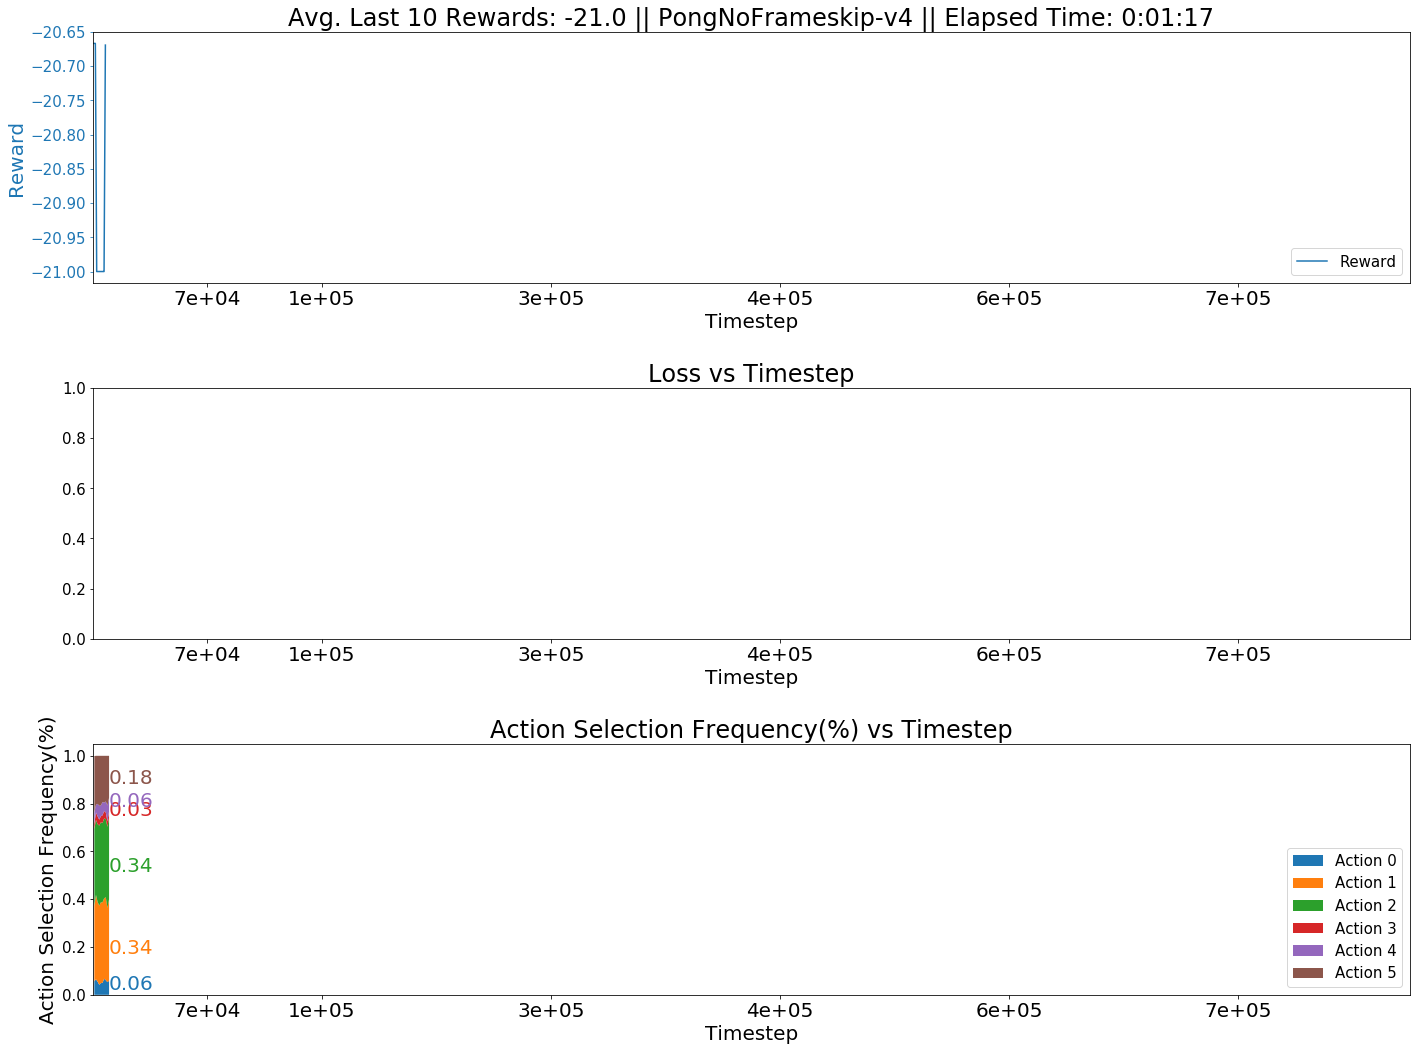

In [ ]:
start=timer()

log_dir = "/tmp/gym/"
try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv')) \
        + glob.glob(os.path.join(log_dir, '*td.csv')) \
        + glob.glob(os.path.join(log_dir, '*sig_param_mag.csv')) \
        + glob.glob(os.path.join(log_dir, '*action_log.csv'))
    for f in files:
        os.remove(f)

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = bench.Monitor(env, os.path.join(log_dir, env_id))
env    = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=True)
env    = WrapPyTorch(env)
model  = Model(env=env, config=config, log_dir=log_dir)

episode_reward = 0

observation = env.reset()
for frame_idx in range(1, config.MAX_FRAMES + 1):
    action = model.get_action(observation)
    model.save_action(action, frame_idx) #log action selection

    prev_observation=observation
    observation, reward, done, _ = env.step(action)
    observation = None if done else observation

    model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward

    if done:
        model.finish_nstep()
        model.reset_hx()
        observation = env.reset()
        model.save_reward(episode_reward)
        episode_reward = 0

    if frame_idx % 10000 == 0:
        model.save_w()
        try:
            clear_output(True)
            plot_all_data(log_dir, env_id, 'RainbowDQN', config.MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)
        except IOError:
            pass

model.save_w()
env.close()
plot_all_data(log_dir, env_id, 'RainbowDQN', config.MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)